In [2]:
# MAIN TODO:
#     - put validation set as early stopping DOING 
#     - show loss functions decrease through epochs (train, test and val) DONE 
#     - put optuna
#     - show correct and incorrect predictions


# Imports

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions

In [4]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

# Setup

In [5]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


# Def MLP

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_function):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.fc_input   = nn.Linear(in_features=input_size, out_features=64)
        self.fc_hidden1 = nn.Linear(in_features=64, out_features=128)
        self.fc_hidden2 = nn.Linear(in_features=128, out_features=64)
        self.fc_output  = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.activation_function(self.fc_input(x))
        x = self.activation_function(self.fc_hidden1(x))
        x = self.activation_function(self.fc_hidden2(x))
        x = self.fc_output(x)
        return x 

# Def hyperparameters and Loaders

In [8]:
input_size          = 32*32*3
num_classes         = 10

# TODO: let this params manipulated
learning_rate       = 0.001
num_epochs          = 100
batch_size          = 16
activation_function = nn.ReLU()

loss_function       = nn.CrossEntropyLoss()

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # to avoid bias
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Main training Loop

In [10]:
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, validation_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break



  1%|          | 1/100 [00:00<00:35,  2.80it/s]

Epoch 1:
Train Loss: 2.3026
Val Loss: 2.3052
Test Loss: 2.3033


  2%|▏         | 2/100 [00:00<00:30,  3.24it/s]

Epoch 2:
Train Loss: 2.3016
Val Loss: 2.3043
Test Loss: 2.3024


  3%|▎         | 3/100 [00:00<00:28,  3.39it/s]

Epoch 3:
Train Loss: 2.3004
Val Loss: 2.3034
Test Loss: 2.3015


  4%|▍         | 4/100 [00:01<00:28,  3.34it/s]

Epoch 4:
Train Loss: 2.2996
Val Loss: 2.3026
Test Loss: 2.3007


  5%|▌         | 5/100 [00:01<00:27,  3.47it/s]

Epoch 5:
Train Loss: 2.2980
Val Loss: 2.3018
Test Loss: 2.2998


  6%|▌         | 6/100 [00:01<00:26,  3.55it/s]

Epoch 6:
Train Loss: 2.2972
Val Loss: 2.3010
Test Loss: 2.2990


  7%|▋         | 7/100 [00:02<00:25,  3.62it/s]

Epoch 7:
Train Loss: 2.2965
Val Loss: 2.3002
Test Loss: 2.2982


  8%|▊         | 8/100 [00:02<00:25,  3.68it/s]

Epoch 8:
Train Loss: 2.2952
Val Loss: 2.2994
Test Loss: 2.2974


  9%|▉         | 9/100 [00:02<00:24,  3.71it/s]

Epoch 9:
Train Loss: 2.2944
Val Loss: 2.2987
Test Loss: 2.2967


 10%|█         | 10/100 [00:02<00:24,  3.74it/s]

Epoch 10:
Train Loss: 2.2937
Val Loss: 2.2979
Test Loss: 2.2959


 11%|█         | 11/100 [00:03<00:24,  3.71it/s]

Epoch 11:
Train Loss: 2.2928
Val Loss: 2.2972
Test Loss: 2.2951


 12%|█▏        | 12/100 [00:03<00:23,  3.71it/s]

Epoch 12:
Train Loss: 2.2920
Val Loss: 2.2965
Test Loss: 2.2944


 13%|█▎        | 13/100 [00:03<00:23,  3.69it/s]

Epoch 13:
Train Loss: 2.2913
Val Loss: 2.2957
Test Loss: 2.2936


 14%|█▍        | 14/100 [00:03<00:24,  3.57it/s]

Epoch 14:
Train Loss: 2.2902
Val Loss: 2.2950
Test Loss: 2.2928


 15%|█▌        | 15/100 [00:04<00:23,  3.59it/s]

Epoch 15:
Train Loss: 2.2894
Val Loss: 2.2943
Test Loss: 2.2920


 16%|█▌        | 16/100 [00:04<00:23,  3.62it/s]

Epoch 16:
Train Loss: 2.2884
Val Loss: 2.2935
Test Loss: 2.2912


 17%|█▋        | 17/100 [00:04<00:22,  3.64it/s]

Epoch 17:
Train Loss: 2.2872
Val Loss: 2.2928
Test Loss: 2.2903


 18%|█▊        | 18/100 [00:05<00:22,  3.66it/s]

Epoch 18:
Train Loss: 2.2861
Val Loss: 2.2920
Test Loss: 2.2894


 19%|█▉        | 19/100 [00:05<00:22,  3.63it/s]

Epoch 19:
Train Loss: 2.2854
Val Loss: 2.2912
Test Loss: 2.2885


 20%|██        | 20/100 [00:05<00:22,  3.60it/s]

Epoch 20:
Train Loss: 2.2847
Val Loss: 2.2903
Test Loss: 2.2876


 21%|██        | 21/100 [00:05<00:21,  3.69it/s]

Epoch 21:
Train Loss: 2.2834
Val Loss: 2.2895
Test Loss: 2.2867


 22%|██▏       | 22/100 [00:06<00:20,  3.74it/s]

Epoch 22:
Train Loss: 2.2825
Val Loss: 2.2886
Test Loss: 2.2857


 23%|██▎       | 23/100 [00:06<00:20,  3.72it/s]

Epoch 23:
Train Loss: 2.2813
Val Loss: 2.2877
Test Loss: 2.2847


 24%|██▍       | 24/100 [00:06<00:21,  3.56it/s]

Epoch 24:
Train Loss: 2.2801
Val Loss: 2.2867
Test Loss: 2.2837


 25%|██▌       | 25/100 [00:06<00:20,  3.62it/s]

Epoch 25:
Train Loss: 2.2793
Val Loss: 2.2858
Test Loss: 2.2826


 26%|██▌       | 26/100 [00:07<00:20,  3.67it/s]

Epoch 26:
Train Loss: 2.2780
Val Loss: 2.2847
Test Loss: 2.2815


 27%|██▋       | 27/100 [00:07<00:19,  3.71it/s]

Epoch 27:
Train Loss: 2.2761
Val Loss: 2.2837
Test Loss: 2.2803


 28%|██▊       | 28/100 [00:07<00:19,  3.70it/s]

Epoch 28:
Train Loss: 2.2755
Val Loss: 2.2826
Test Loss: 2.2791


 29%|██▉       | 29/100 [00:08<00:19,  3.71it/s]

Epoch 29:
Train Loss: 2.2737
Val Loss: 2.2815
Test Loss: 2.2778


 30%|███       | 30/100 [00:08<00:18,  3.69it/s]

Epoch 30:
Train Loss: 2.2718
Val Loss: 2.2803
Test Loss: 2.2765


 31%|███       | 31/100 [00:08<00:18,  3.70it/s]

Epoch 31:
Train Loss: 2.2709
Val Loss: 2.2790
Test Loss: 2.2751


 32%|███▏      | 32/100 [00:08<00:18,  3.72it/s]

Epoch 32:
Train Loss: 2.2695
Val Loss: 2.2778
Test Loss: 2.2737


 33%|███▎      | 33/100 [00:09<00:17,  3.76it/s]

Epoch 33:
Train Loss: 2.2684
Val Loss: 2.2764
Test Loss: 2.2722


 34%|███▍      | 34/100 [00:09<00:18,  3.66it/s]

Epoch 34:
Train Loss: 2.2660
Val Loss: 2.2750
Test Loss: 2.2707


 35%|███▌      | 35/100 [00:09<00:17,  3.67it/s]

Epoch 35:
Train Loss: 2.2644
Val Loss: 2.2736
Test Loss: 2.2690


 36%|███▌      | 36/100 [00:09<00:17,  3.70it/s]

Epoch 36:
Train Loss: 2.2630
Val Loss: 2.2721
Test Loss: 2.2674


 37%|███▋      | 37/100 [00:10<00:16,  3.73it/s]

Epoch 37:
Train Loss: 2.2616
Val Loss: 2.2706
Test Loss: 2.2656


 38%|███▊      | 38/100 [00:10<00:17,  3.59it/s]

Epoch 38:
Train Loss: 2.2594
Val Loss: 2.2690
Test Loss: 2.2637


 39%|███▉      | 39/100 [00:10<00:16,  3.62it/s]

Epoch 39:
Train Loss: 2.2577
Val Loss: 2.2673
Test Loss: 2.2618


 40%|████      | 40/100 [00:11<00:16,  3.66it/s]

Epoch 40:
Train Loss: 2.2550
Val Loss: 2.2655
Test Loss: 2.2597


 41%|████      | 41/100 [00:11<00:15,  3.70it/s]

Epoch 41:
Train Loss: 2.2530
Val Loss: 2.2637
Test Loss: 2.2576


 42%|████▏     | 42/100 [00:11<00:15,  3.74it/s]

Epoch 42:
Train Loss: 2.2509
Val Loss: 2.2618
Test Loss: 2.2554


 43%|████▎     | 43/100 [00:11<00:15,  3.76it/s]

Epoch 43:
Train Loss: 2.2483
Val Loss: 2.2599
Test Loss: 2.2530


 44%|████▍     | 44/100 [00:12<00:14,  3.81it/s]

Epoch 44:
Train Loss: 2.2456
Val Loss: 2.2578
Test Loss: 2.2506


 45%|████▌     | 45/100 [00:12<00:14,  3.84it/s]

Epoch 45:
Train Loss: 2.2432
Val Loss: 2.2557
Test Loss: 2.2481


 46%|████▌     | 46/100 [00:12<00:13,  3.86it/s]

Epoch 46:
Train Loss: 2.2406
Val Loss: 2.2535
Test Loss: 2.2454


 47%|████▋     | 47/100 [00:12<00:13,  3.85it/s]

Epoch 47:
Train Loss: 2.2371
Val Loss: 2.2511
Test Loss: 2.2427


 48%|████▊     | 48/100 [00:13<00:13,  3.85it/s]

Epoch 48:
Train Loss: 2.2357
Val Loss: 2.2488
Test Loss: 2.2399


 49%|████▉     | 49/100 [00:13<00:13,  3.78it/s]

Epoch 49:
Train Loss: 2.2322
Val Loss: 2.2463
Test Loss: 2.2370


 50%|█████     | 50/100 [00:13<00:13,  3.72it/s]

Epoch 50:
Train Loss: 2.2292
Val Loss: 2.2438
Test Loss: 2.2340


 51%|█████     | 51/100 [00:13<00:13,  3.72it/s]

Epoch 51:
Train Loss: 2.2264
Val Loss: 2.2412
Test Loss: 2.2310


 52%|█████▏    | 52/100 [00:14<00:13,  3.64it/s]

Epoch 52:
Train Loss: 2.2238
Val Loss: 2.2386
Test Loss: 2.2279


 53%|█████▎    | 53/100 [00:14<00:12,  3.66it/s]

Epoch 53:
Train Loss: 2.2192
Val Loss: 2.2359
Test Loss: 2.2247


 54%|█████▍    | 54/100 [00:14<00:12,  3.67it/s]

Epoch 54:
Train Loss: 2.2167
Val Loss: 2.2331
Test Loss: 2.2215


 55%|█████▌    | 55/100 [00:14<00:12,  3.68it/s]

Epoch 55:
Train Loss: 2.2135
Val Loss: 2.2303
Test Loss: 2.2182


 56%|█████▌    | 56/100 [00:15<00:11,  3.67it/s]

Epoch 56:
Train Loss: 2.2099
Val Loss: 2.2275
Test Loss: 2.2148


 57%|█████▋    | 57/100 [00:15<00:11,  3.63it/s]

Epoch 57:
Train Loss: 2.2071
Val Loss: 2.2247
Test Loss: 2.2115


 58%|█████▊    | 58/100 [00:15<00:11,  3.67it/s]

Epoch 58:
Train Loss: 2.2040
Val Loss: 2.2218
Test Loss: 2.2082


 59%|█████▉    | 59/100 [00:16<00:11,  3.64it/s]

Epoch 59:
Train Loss: 2.2004
Val Loss: 2.2189
Test Loss: 2.2048


 60%|██████    | 60/100 [00:16<00:10,  3.70it/s]

Epoch 60:
Train Loss: 2.1947
Val Loss: 2.2160
Test Loss: 2.2014


 61%|██████    | 61/100 [00:16<00:10,  3.74it/s]

Epoch 61:
Train Loss: 2.1932
Val Loss: 2.2130
Test Loss: 2.1980


 62%|██████▏   | 62/100 [00:16<00:10,  3.77it/s]

Epoch 62:
Train Loss: 2.1894
Val Loss: 2.2101
Test Loss: 2.1945


 63%|██████▎   | 63/100 [00:17<00:09,  3.81it/s]

Epoch 63:
Train Loss: 2.1851
Val Loss: 2.2071
Test Loss: 2.1911


 64%|██████▍   | 64/100 [00:17<00:09,  3.81it/s]

Epoch 64:
Train Loss: 2.1819
Val Loss: 2.2040
Test Loss: 2.1876


 65%|██████▌   | 65/100 [00:17<00:09,  3.83it/s]

Epoch 65:
Train Loss: 2.1794
Val Loss: 2.2010
Test Loss: 2.1842


 66%|██████▌   | 66/100 [00:17<00:09,  3.71it/s]

Epoch 66:
Train Loss: 2.1744
Val Loss: 2.1979
Test Loss: 2.1808


 67%|██████▋   | 67/100 [00:18<00:08,  3.71it/s]

Epoch 67:
Train Loss: 2.1702
Val Loss: 2.1949
Test Loss: 2.1773


 68%|██████▊   | 68/100 [00:18<00:08,  3.76it/s]

Epoch 68:
Train Loss: 2.1678
Val Loss: 2.1918
Test Loss: 2.1739


 69%|██████▉   | 69/100 [00:18<00:08,  3.74it/s]

Epoch 69:
Train Loss: 2.1629
Val Loss: 2.1887
Test Loss: 2.1705


 70%|███████   | 70/100 [00:19<00:08,  3.73it/s]

Epoch 70:
Train Loss: 2.1592
Val Loss: 2.1855
Test Loss: 2.1670


 71%|███████   | 71/100 [00:19<00:07,  3.75it/s]

Epoch 71:
Train Loss: 2.1565
Val Loss: 2.1824
Test Loss: 2.1636


 72%|███████▏  | 72/100 [00:19<00:07,  3.79it/s]

Epoch 72:
Train Loss: 2.1516
Val Loss: 2.1793
Test Loss: 2.1601


 73%|███████▎  | 73/100 [00:19<00:07,  3.81it/s]

Epoch 73:
Train Loss: 2.1485
Val Loss: 2.1761
Test Loss: 2.1567


 74%|███████▍  | 74/100 [00:20<00:06,  3.84it/s]

Epoch 74:
Train Loss: 2.1437
Val Loss: 2.1728
Test Loss: 2.1532


 75%|███████▌  | 75/100 [00:20<00:06,  3.86it/s]

Epoch 75:
Train Loss: 2.1399
Val Loss: 2.1696
Test Loss: 2.1498


 76%|███████▌  | 76/100 [00:20<00:06,  3.75it/s]

Epoch 76:
Train Loss: 2.1368
Val Loss: 2.1664
Test Loss: 2.1464


 77%|███████▋  | 77/100 [00:20<00:06,  3.79it/s]

Epoch 77:
Train Loss: 2.1318
Val Loss: 2.1632
Test Loss: 2.1430


 78%|███████▊  | 78/100 [00:21<00:05,  3.76it/s]

Epoch 78:
Train Loss: 2.1294
Val Loss: 2.1599
Test Loss: 2.1396


 79%|███████▉  | 79/100 [00:21<00:05,  3.75it/s]

Epoch 79:
Train Loss: 2.1213
Val Loss: 2.1567
Test Loss: 2.1362


 80%|████████  | 80/100 [00:21<00:05,  3.78it/s]

Epoch 80:
Train Loss: 2.1204
Val Loss: 2.1534
Test Loss: 2.1328


 81%|████████  | 81/100 [00:21<00:05,  3.64it/s]

Epoch 81:
Train Loss: 2.1163
Val Loss: 2.1501
Test Loss: 2.1294


 82%|████████▏ | 82/100 [00:22<00:04,  3.66it/s]

Epoch 82:
Train Loss: 2.1131
Val Loss: 2.1468
Test Loss: 2.1261


 83%|████████▎ | 83/100 [00:22<00:04,  3.59it/s]

Epoch 83:
Train Loss: 2.1093
Val Loss: 2.1435
Test Loss: 2.1227


 84%|████████▍ | 84/100 [00:22<00:04,  3.66it/s]

Epoch 84:
Train Loss: 2.1035
Val Loss: 2.1401
Test Loss: 2.1193


 85%|████████▌ | 85/100 [00:23<00:04,  3.72it/s]

Epoch 85:
Train Loss: 2.0995
Val Loss: 2.1368
Test Loss: 2.1159


 86%|████████▌ | 86/100 [00:23<00:03,  3.73it/s]

Epoch 86:
Train Loss: 2.0970
Val Loss: 2.1335
Test Loss: 2.1126


 87%|████████▋ | 87/100 [00:23<00:03,  3.78it/s]

Epoch 87:
Train Loss: 2.0914
Val Loss: 2.1303
Test Loss: 2.1093


 88%|████████▊ | 88/100 [00:23<00:03,  3.77it/s]

Epoch 88:
Train Loss: 2.0871
Val Loss: 2.1271
Test Loss: 2.1060


 89%|████████▉ | 89/100 [00:24<00:02,  3.76it/s]

Epoch 89:
Train Loss: 2.0847
Val Loss: 2.1237
Test Loss: 2.1028


 90%|█████████ | 90/100 [00:24<00:02,  3.74it/s]

Epoch 90:
Train Loss: 2.0814
Val Loss: 2.1205
Test Loss: 2.0996


 91%|█████████ | 91/100 [00:24<00:02,  3.67it/s]

Epoch 91:
Train Loss: 2.0759
Val Loss: 2.1171
Test Loss: 2.0963


 92%|█████████▏| 92/100 [00:24<00:02,  3.57it/s]

Epoch 92:
Train Loss: 2.0713
Val Loss: 2.1139
Test Loss: 2.0931


 93%|█████████▎| 93/100 [00:25<00:01,  3.58it/s]

Epoch 93:
Train Loss: 2.0671
Val Loss: 2.1106
Test Loss: 2.0900


 94%|█████████▍| 94/100 [00:25<00:01,  3.63it/s]

Epoch 94:
Train Loss: 2.0639
Val Loss: 2.1075
Test Loss: 2.0869


 95%|█████████▌| 95/100 [00:25<00:01,  3.68it/s]

Epoch 95:
Train Loss: 2.0588
Val Loss: 2.1044
Test Loss: 2.0838


 96%|█████████▌| 96/100 [00:25<00:01,  3.75it/s]

Epoch 96:
Train Loss: 2.0550
Val Loss: 2.1013
Test Loss: 2.0808


 97%|█████████▋| 97/100 [00:26<00:00,  3.78it/s]

Epoch 97:
Train Loss: 2.0517
Val Loss: 2.0982
Test Loss: 2.0777


 98%|█████████▊| 98/100 [00:26<00:00,  3.75it/s]

Epoch 98:
Train Loss: 2.0471
Val Loss: 2.0949
Test Loss: 2.0746


 99%|█████████▉| 99/100 [00:26<00:00,  3.78it/s]

Epoch 99:
Train Loss: 2.0408
Val Loss: 2.0919
Test Loss: 2.0717


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]

Epoch 100:
Train Loss: 2.0389
Val Loss: 2.0889
Test Loss: 2.0688


# Evaluate best model

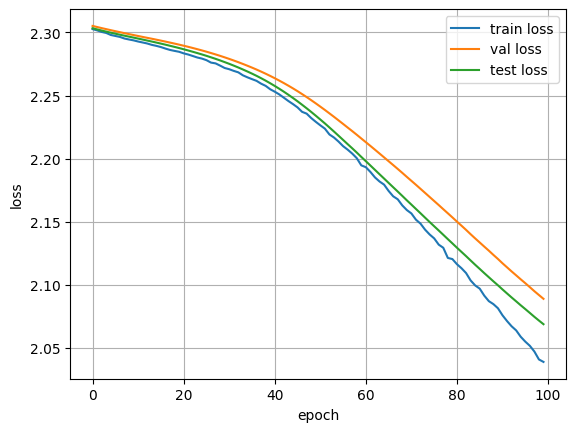

In [11]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

In [12]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}")

Scores of your model
 {'accuracy': 0.241, 'balanced_accuracy': np.float64(0.22797030797583612), 'f1_score': 0.15060784835093863, 'precision': 0.255874264189641, 'recall': 0.241}


/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
